# Windy Gridworld

Imagine a standard gridworld, with start and goal states, but with one difference: there is a crosswind running upward through the middle of the grid. The actions are the standard four -`up`, `down`, `right`, `left`- but in the middle region the resultant next states are shifted upward by "wind", the strength of which varies from column to column.

This is an undiscounted episodic task, with **constant rewards of -1** until the goal is reached.

## Windy Gridworld Static Wind

Let's say the first 3 columns don't have wind, the next 3 columns have wind by 1, then the next 2 columns have wind by 2, then 1 and finally 0. So, we have a griworld of 10 columns.

In [59]:
from TD_methods import td_sarsa_control
import numpy as np

In [60]:
# Let's create just the gridworld
gridworld = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 2, 2, 1, 0, 0] # This row represents the wind in each column
])

In [61]:
n, m = gridworld.shape

Say that a state is represented by a tuple, which has the position in the first index, and the wind in the second.

In [62]:
non_terminal_states=[]
terminal_states=[]
initial_states=[]
for i in range(n-1):
    for j in range(m):
        if gridworld[i, j] != 0:
            if gridworld[i, j] == 1:
                non_terminal_states.append(((i, j), gridworld[n-1, j]))
            elif gridworld[i, j] == 2:
                initial_states.append(((i, j), gridworld[n-1, j]))
                non_terminal_states.append(((i, j), gridworld[n-1, j]))
            else:
                terminal_states.append(((i, j), gridworld[n-1, j]))

In [130]:
actions={}
states = non_terminal_states + terminal_states
for state in states:
    actions[state] = [action for action in ['up', 'down', 'right', 'left']]

In [64]:
def next_step_static_wind(state, action):
    """
    Takes as input a state and an action, and returns a (state, reward) tuple that follows the state-action pair.
    """
    def invalid_position(position: tuple):
        if gridworld[position] == 0:
            return True
    i, j = state[0]
    wind = state[1]

    if action == 'up':
        new_position_without_wind = (i - 1, j)
    elif action == 'down':
        new_position_without_wind = (i + 1, j)
    elif action == 'right':
        new_position_without_wind = (i, j + 1)
    elif action == 'left':
        new_position_without_wind = (i, j - 1)
    else:
        raise ValueError("This action does not exists!")
    
    if invalid_position(new_position_without_wind):
        return (state, -1)
    
    new_position = (new_position_without_wind[0] - wind, new_position_without_wind[1])
    # The next state depends on thw wind, and wind depends on the 'j'
    new_wind = gridworld[n-1, new_position[1]]
    if invalid_position(new_position):
        return (((new_position_without_wind), new_wind), -1)
    return (((new_position), new_wind), -1)

In [65]:
def next_step_static_wind(state, action):
    """
    Simula un paso en el gridworld con viento.
    Primero aplica la acción, y luego aplica el viento hacia arriba, 
    desplazándose lo más posible hasta encontrar una pared.
    """
    def is_valid(position):
        i, j = position
        if 0 <= i < gridworld.shape[0] and 0 <= j < gridworld.shape[1]:
            return gridworld[i, j] != 0
        return False

    i, j = state[0]
    wind = state[1]

    # Aplica acción
    if action == 'up':
        i2, j2 = i - 1, j
    elif action == 'down':
        i2, j2 = i + 1, j
    elif action == 'right':
        i2, j2 = i, j + 1
    elif action == 'left':
        i2, j2 = i, j - 1
    else:
        raise ValueError("Acción inválida")

    # Verifica si el movimiento por acción es válido
    if not is_valid((i2, j2)):
        return (state, -1)

    # Aplica el viento hacia arriba, paso a paso
    for _ in range(wind):
        if is_valid((i2 - 1, j2)):
            i2 -= 1
        else:
            break  # Se choca con la pared y se detiene

    new_state = ((i2, j2), gridworld[-1, j2])
    return (new_state, -1)


In [66]:
initial_Q = {}
for s in states:
    initial_Q[s] = {}
    for a in actions[s]:
        initial_Q[s][a] = 0

### Execute the algorithm to find the solution

In [102]:
Q, policy = td_sarsa_control(non_terminal_states=non_terminal_states,
                 terminal_states=terminal_states,
                 initial_states=initial_states,
                 actions=actions,
                 next_step_fn=next_step_static_wind,
                 gamma=1.0,
                 alpha=0.2,
                 epsilon=0.1,
                 num_episodes=1000,
                 initial_Q=initial_Q)

### Find the optimal path

In [119]:
state = initial_states[0]
actions_optimal_path = []
states_optimal_path = []
while state not in terminal_states:
    action = policy[state]
    actions_optimal_path.append(action)
    state = next_step_static_wind(state, action)[0]
    states_optimal_path.append(state)

### Create the solution plot

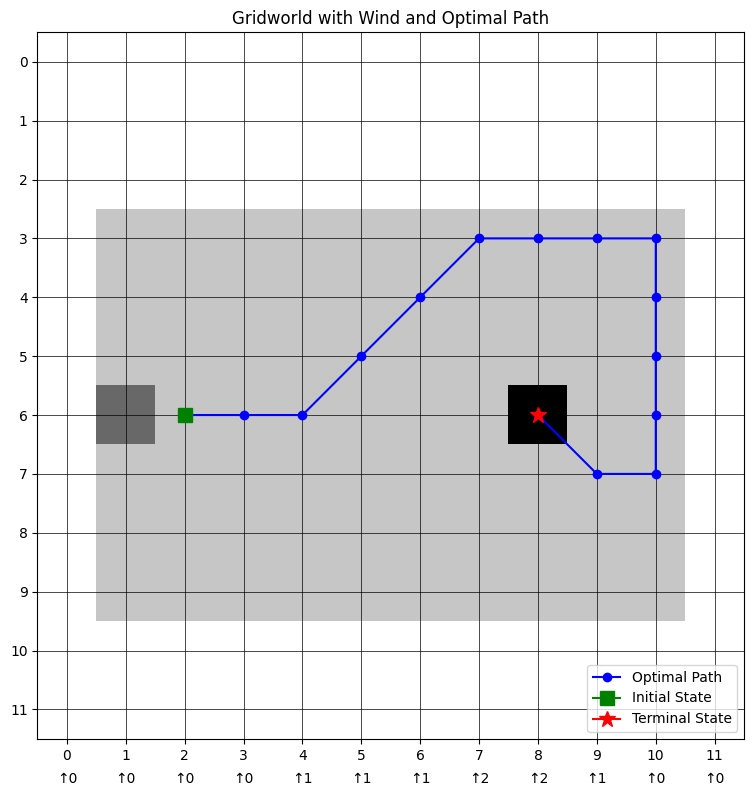

In [124]:
import matplotlib.pyplot as plt

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Mostrar el grid (sin la fila del viento)
ax.imshow(gridworld[:12, :], cmap="Greys", origin="upper")

# Coordenadas del camino
path_coords = [s[0] for s in states_optimal_path]
x_coords = [s[1] for s in path_coords]
y_coords = [s[0] for s in path_coords]

# Dibujar el camino óptimo
ax.plot(x_coords, y_coords, marker='o', color='blue', label='Optimal Path')

# Estado inicial y final
initial_state = path_coords[0]
terminal_state = path_coords[-1]
ax.plot(initial_state[1], initial_state[0], marker='s', color='green', markersize=10, label='Initial State')
ax.plot(terminal_state[1], terminal_state[0], marker='*', color='red', markersize=12, label='Terminal State')

# Dibujar el viento debajo de la última fila visible
for col, wind in enumerate(gridworld[-1]):
    ax.text(col, gridworld.shape[0] - 1 + 0.3, f"↑{wind}", ha='center', va='bottom', fontsize=10, color='black')

# Ajustes visuales
ax.set_xticks(np.arange(gridworld.shape[1]))
ax.set_yticks(np.arange(gridworld.shape[0] - 1))
ax.grid(True, color='black', linewidth=0.5)
ax.set_title("Gridworld with Wind and Optimal Path")
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()